In [ ]:
# PARAMETERS & PATHS (Papermill-friendly) + Upload Gate
# This cell defines configurable inputs and base directories.
import os
import shutil

# Base directory
if 'RETAILSENSE_BASE_DIR' not in globals() or not RETAILSENSE_BASE_DIR:
    RETAILSENSE_BASE_DIR = r"F:\RetailSense_Lite"

BASE_DIR = RETAILSENSE_BASE_DIR
RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
UPLOAD_DIR = os.path.join(BASE_DIR, 'data', 'uploaded')
DEFAULT_UPLOAD_PATH = os.path.join(UPLOAD_DIR, 'uploaded_data.csv')

os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(UPLOAD_DIR, exist_ok=True)

# Uploaded data path gate (env override allowed)
UPLOADED_DATA_PATH = os.getenv('UPLOADED_DATA_PATH')
if not UPLOADED_DATA_PATH or not UPLOADED_DATA_PATH.strip():
    UPLOADED_DATA_PATH = DEFAULT_UPLOAD_PATH
UPLOADED_DATA_PATH = os.path.normpath(UPLOADED_DATA_PATH)

# For Phase 1, INPUT_CSV must be the uploaded file
INPUT_CSV = UPLOADED_DATA_PATH

# Utility: Clear Phase 1 outputs (avoid stale results)
def clear_phase1_outputs():
    try:
        # Remove Phase 1 processed outputs
        for fname in [
            os.path.join(PROCESSED_DIR, 'raw2.csv'),
            os.path.join(PROCESSED_DIR, 'cleaned_data.csv')
        ]:
            if os.path.exists(fname):
                os.remove(fname)
        print("🧹 Phase 1 outputs cleared (raw2.csv, cleaned_data.csv)")
    except Exception as e:
        print(f"⚠️ Could not clear some Phase 1 outputs: {e}")

# Determine gate status
SKIP_PHASE1 = False
if not os.path.exists(INPUT_CSV):
    clear_phase1_outputs()
    SKIP_PHASE1 = True
    print("❌ No uploaded data file found for Phase 1.")
    print("   Set env 'UPLOADED_DATA_PATH' or place file at: " + DEFAULT_UPLOAD_PATH)
    print("   Phase 1 execution will be skipped to avoid stale results.")
else:
    # Clear any previous outputs to ensure fresh run
    clear_phase1_outputs()
    print(f"✅ Using uploaded data file for Phase 1: {INPUT_CSV}")

print(f"📁 BASE_DIR: {BASE_DIR}")

In [ ]:
# Cell 1: Import Libraries and Load Your Dataset (Guarded by upload gate)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("🛒 RetailSense Lite - Custom Dataset Analysis")
print("=" * 60)

# Upload gate
if 'SKIP_PHASE1' in globals() and SKIP_PHASE1:
    print("⏭️ Skipping Phase 1: No uploaded data file.")
else:
    # Load your dataset using uploaded INPUT_CSV
    if not os.path.exists(INPUT_CSV):
        raise FileNotFoundError(f"Input CSV not found: {INPUT_CSV}")

    df = pd.read_csv(INPUT_CSV)

    print(f"✅ Dataset loaded: {df.shape}")
    print("\n📊 Column Names:")
    print(df.columns.tolist())

🛒 RetailSense Lite - Custom Dataset Analysis
✅ Dataset loaded: (12000, 15)

📊 Column Names:
['category', 'product_name', 'week_no', 'week_start', 'week_end', 'sales_qty', 'stock_on_hand', 'availability', 'price', 'promotion', 'holiday_flag', 'season', 'weather', 'disaster_flag', 'expiry_date']


In [ ]:
# Cell 2: Product Selection for Forecasting
# =========================================

import pandas as pd
import matplotlib.pyplot as plt
import os

if 'SKIP_PHASE1' in globals() and SKIP_PHASE1:
    print("⏭️ Skipping product selection (no uploaded data).")
else:
    file_path = INPUT_CSV
    df = pd.read_csv(file_path)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    if 'product_name' in df.columns:
        unique_products = df['product_name'].unique()
        print(f"🛍️ Available Products: {len(unique_products)}")
        print(unique_products[:20])
        env_input = os.environ.get("PRODUCT_NAME", "").strip()
        if env_input in unique_products:
            selected_product = env_input
        else:
            selected_product = unique_products[0]
            if env_input != "":
                print(f"⚠️ Product '{env_input}' not found. Using default: {selected_product}")
            else:
                print(f"✅ Using default product: {selected_product}")
        product_df = df[df['product_name'] == selected_product].copy()
        if 'date' in product_df.columns:
            agg_cols = {"sales_qty": "sum"}
            if 'revenue' in product_df.columns:
                agg_cols["revenue"] = "sum"
            sales_by_date = (
                product_df.groupby('date')
                .agg(agg_cols)
                .reset_index()
                .sort_values('date')
            )
            print(f"📊 Filtered dataset size: {sales_by_date.shape}")
            print(sales_by_date.head())
            plt.figure(figsize=(12,5))
            plt.plot(sales_by_date['date'], sales_by_date['sales_qty'], marker='o')
            plt.title(f"📈 Sales Trend for {selected_product}")
            plt.xlabel("Date")
            plt.ylabel("Sales Quantity")
            plt.grid(True)
            plt.show()
        else:
            print("ℹ️ 'date' column not found; skipping time series plot.")
    else:
        print("❌ 'product_name' column not found in dataset. Please check the file format.")

🛍️ Available Products: 44
['Cheese' 'Dal' 'Biscuits' 'Tomato' 'Paneer' 'Curd' 'Toothpaste' 'Oats'
 'Tea' 'Juice' 'Milk' 'Guava' 'Rice' 'Mango' 'Wheat' 'Apple' 'Atta'
 'Energy Drink' 'Soft Drink' 'Chips']


In [ ]:
# Cell 2: Data Overview and Quality Check (Guarded)
import pandas as pd

if 'SKIP_PHASE1' in globals() and SKIP_PHASE1:
    print("⏭️ Skipping data overview (no uploaded data).")
else:
    print("🔍 DATA OVERVIEW")
    print("=" * 50)

    print("\n📋 Dataset Info:")
    df.info()

    print("\n📊 Basic Statistics:")
    print(df.describe(include='all').transpose())   # include categorical stats too

    print("\n❓ Missing Values Check:")
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing_values,
        'Missing_Percentage': missing_percent.round(2)
    }).sort_values('Missing_Count', ascending=False)

    if missing_df['Missing_Count'].sum() == 0:
        print("✅ No missing values found.")
    else:
        print(missing_df[missing_df['Missing_Count'] > 0])

    if "store_id" in df.columns:
        print(f"\n🏪 Unique Stores: {df['store_id'].nunique()}")

    if "product_id" in df.columns:
        print(f"📦 Unique Products: {df['product_id'].nunique()}")

    if "category" in df.columns:
        print(f"🏷️ Unique Categories: {df['category'].nunique()}")

    if "week_start" in df.columns and "week_end" in df.columns:
        df["week_start"] = pd.to_datetime(df["week_start"], errors="coerce")
        df["week_end"] = pd.to_datetime(df["week_end"], errors="coerce")
        print(f"📅 Date Range: {df['week_start'].min().date()} to {df['week_end'].max().date()}")

    print("\n📝 Columns in DataFrame:")
    print(df.columns.tolist())

🔍 DATA OVERVIEW

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category       12000 non-null  object 
 1   product_name   12000 non-null  object 
 2   week_no        12000 non-null  int64  
 3   week_start     12000 non-null  object 
 4   week_end       12000 non-null  object 
 5   sales_qty      12000 non-null  int64  
 6   stock_on_hand  12000 non-null  int64  
 7   availability   12000 non-null  int64  
 8   price          12000 non-null  float64
 9   promotion      12000 non-null  int64  
 10  holiday_flag   12000 non-null  int64  
 11  season         12000 non-null  object 
 12  weather        12000 non-null  object 
 13  disaster_flag  12000 non-null  int64  
 14  expiry_date    12000 non-null  object 
dtypes: float64(1), int64(7), object(7)
memory usage: 1.4+ MB

📊 Basic Statistics:
                 count uniq

In [ ]:
# Cell 3: Null Handling with Averages + Save Raw2 Dataset (Guarded)
import numpy as np
import pandas as pd
import os

if 'SKIP_PHASE1' in globals() and SKIP_PHASE1:
    print("⏭️ Skipping null handling (no uploaded data).")
else:
    print("🛠️ NULL HANDLING WITH AVERAGES")
    print("=" * 50)

    raw_data_path = INPUT_CSV   # uploaded input
    if not os.path.exists(raw_data_path):
        raise FileNotFoundError(f"❌ Input CSV not found: {raw_data_path}")

    df = pd.read_csv(raw_data_path)

    print(f"✅ Loaded raw data: {raw_data_path}")
    print(f"📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns

    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            mean_val = df[col].mean()
            df[col].fillna(mean_val, inplace=True)
            print(f"✅ Filled NaN in numeric column '{col}' with mean ({mean_val:.2f})")

    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"✅ Filled NaN in categorical column '{col}' with mode ('{mode_val}')")

    print("\n🔍 Remaining Missing Values Check:")
    print(df.isnull().sum()[df.isnull().sum() > 0])

    os.makedirs(PROCESSED_DIR, exist_ok=True)
    save_path = os.path.join(PROCESSED_DIR, "raw2.csv")

    df.to_csv(save_path, index=False)

    print(f"\n💾 Intermediate dataset saved to: {save_path}")
    print("➡️ Use this file as input for Cell 4 (preprocessing).")

🛠️ NULL HANDLING WITH AVERAGES
✅ Loaded raw data: F:\RetailSense_Lite\data\raw\market.csv
📊 Shape: 12000 rows × 15 columns

🔍 Remaining Missing Values Check:
Series([], dtype: int64)

💾 Intermediate dataset saved to: F:\RetailSense_Lite\data\processed\raw2.csv
➡️ Use this file as input for Cell 4 (preprocessing).


In [ ]:
# -------------------
# Phase 1 - Cell 4: Data Preprocessing & Save Cleaned Dataset (Guarded)
# -------------------
import pandas as pd
import os

if 'SKIP_PHASE1' in globals() and SKIP_PHASE1:
    print("⏭️ Skipping preprocessing (no uploaded data).")
else:
    print("🔧 DATA PREPROCESSING")
    print("=" * 40)

    def preprocess_retail_data(df):
        df = df.copy()
        date_columns = ['week_start', 'week_end', 'expiry_date']
        for col in date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
        if 'week_start' in df.columns:
            df['year'] = df['week_start'].dt.year
            df['month'] = df['week_start'].dt.month
        if 'category' in df.columns:
            df['category_encoded'] = pd.Categorical(df['category']).codes
        for col in ['season', 'weather']:
            if col in df.columns:
                dummies = pd.get_dummies(df[col], prefix=col)
                df = pd.concat([df, dummies], axis=1)
                df.drop(columns=[col], inplace=True)
        binary_columns = ['promotion', 'holiday_flag', 'disaster_flag', 'availability']
        for col in binary_columns:
            if col in df.columns:
                df[col] = df[col].fillna(0).astype(int)
        if 'price' in df.columns and 'sales_qty' in df.columns:
            df['revenue'] = df['price'] * df['sales_qty']
        return df

    print("📂 Loading intermediate dataset from Cell 3 (raw2.csv)...")
    input_path = os.path.join(PROCESSED_DIR, "raw2.csv")
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"❌ raw2.csv not found at: {input_path}")

    df = pd.read_csv(input_path)
    df_cleaned = preprocess_retail_data(df)

    print(f"✅ Preprocessing complete!")
    print(f"📊 Final shape: {df_cleaned.shape}")

    save_path = os.path.join(PROCESSED_DIR, "cleaned_data.csv")
    df_cleaned.to_csv(save_path, index=False)

    print(f"💾 Cleaned dataset saved at: {save_path}")

🔧 DATA PREPROCESSING
📂 Loading intermediate dataset from Cell 3 (raw2.csv)...


✅ Preprocessing complete!
📊 Final shape: (12000, 24)
💾 Cleaned dataset saved at: F:\RetailSense_Lite\data\processed\cleaned_data.csv


📦 INVENTORY ANALYSIS (Phase 1 - Cleaned Data)
✅ Loaded cleaned data: ../data/processed/cleaned_data.csv
📊 Records: 12000, Columns: 24
📊 Average Stock on Hand: 275.61 units
🚨 Low Stock Threshold (10th percentile): 93.00 units
📈 Correlation (Stock vs Sales): 0.00
⚠️ Items with Low Stock: 1202


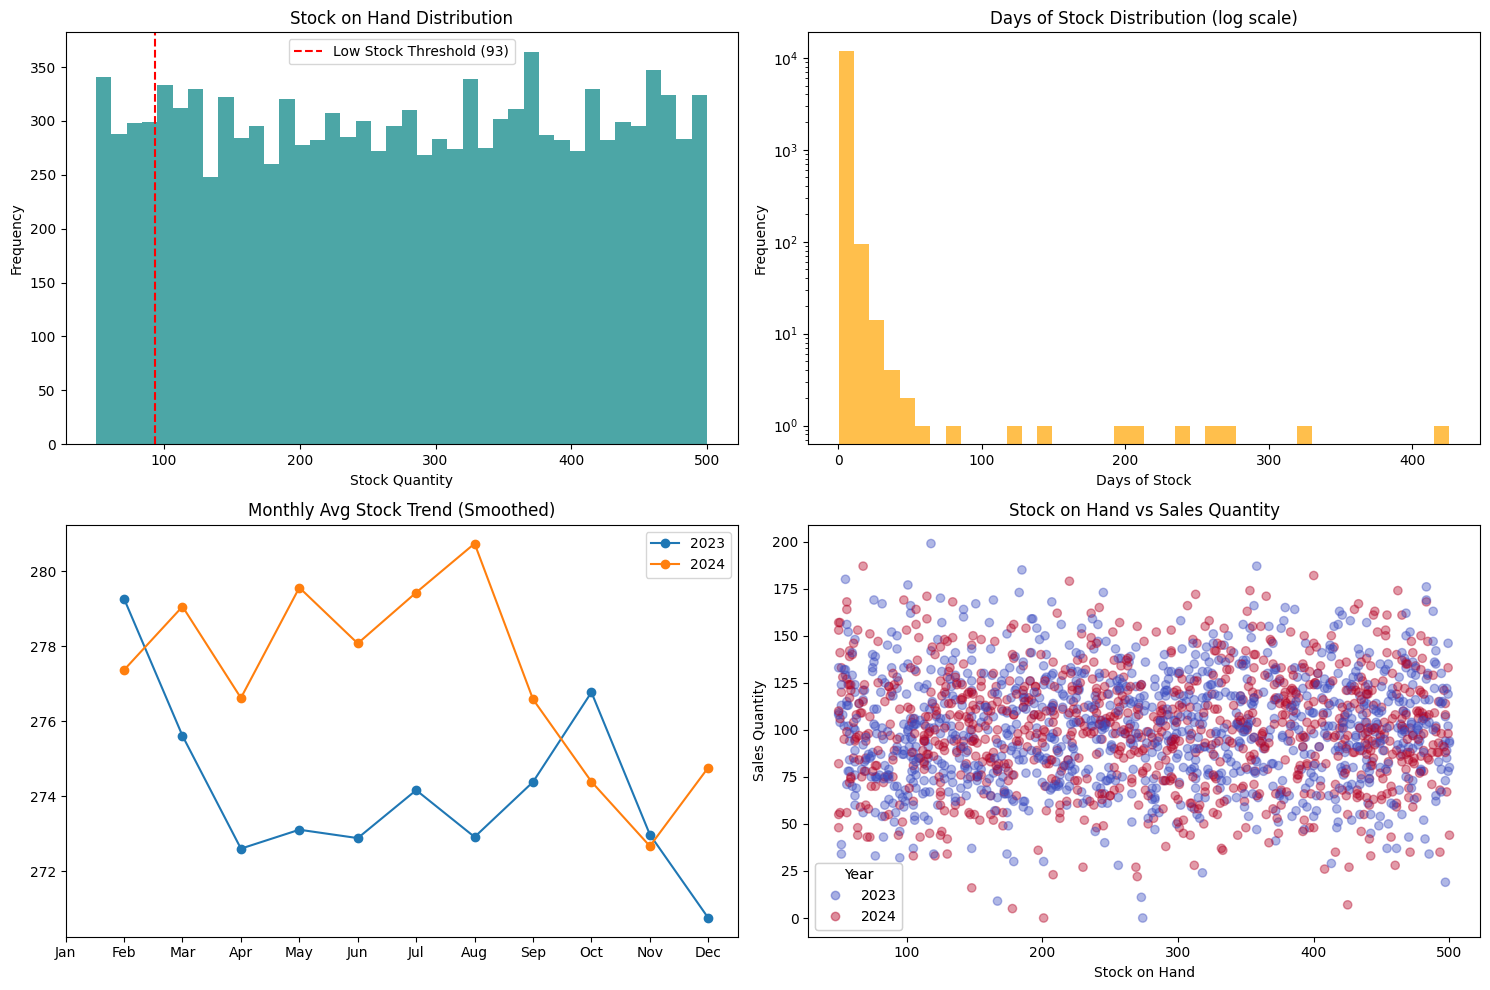

In [ ]:
# -------------------
# Phase 1 - Cell 5: Inventory Analysis (Cleaned Data) - Robust Version (Guarded)
# -------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

if 'SKIP_PHASE1' in globals() and SKIP_PHASE1:
    print("⏭️ Skipping inventory analysis (no uploaded data).")
else:
    print("📦 INVENTORY ANALYSIS (Phase 1 - Cleaned Data)")
    print("=" * 50)

    possible_paths = [
        os.path.join(PROCESSED_DIR, "cleaned_data.csv"),
        "../data/processed/cleaned_data.csv",
        "./data/processed/cleaned_data.csv",
    ]

    DATA_PATH = None
    for p in possible_paths:
        if os.path.exists(p):
            DATA_PATH = p
            break

    if DATA_PATH is None:
        raise FileNotFoundError(
            "❌ cleaned_data.csv not found in expected locations.\n"
            "👉 Please check your working directory or re-run Phase 1 preprocessing."
        )

    df_cleaned = pd.read_csv(DATA_PATH)
    print(f"✅ Loaded cleaned data: {DATA_PATH}")
    print(f"📊 Records: {df_cleaned.shape[0]}, Columns: {df_cleaned.shape[1]}")

    if 'stock_on_hand' in df_cleaned.columns:
        avg_stock = df_cleaned['stock_on_hand'].mean()
        low_stock_threshold = df_cleaned['stock_on_hand'].quantile(0.1)
        corr_stock_sales = (
            df_cleaned[['stock_on_hand','sales_qty']].corr().iloc[0,1]
            if 'sales_qty' in df_cleaned.columns else np.nan
        )

        print(f"📊 Average Stock on Hand: {avg_stock:.2f} units")
        print(f"🚨 Low Stock Threshold (10th percentile): {low_stock_threshold:.2f} units")
        if not np.isnan(corr_stock_sales):
            print(f"📈 Correlation (Stock vs Sales): {corr_stock_sales:.2f}")

        low_stock_items = df_cleaned[df_cleaned['stock_on_hand'] <= low_stock_threshold]
        print(f"⚠️ Items with Low Stock: {len(low_stock_items)}")

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes[0,0].hist(df_cleaned['stock_on_hand'], bins=40, alpha=0.7, color='teal')
        axes[0,0].axvline(low_stock_threshold, color='red', linestyle='--', 
                         label=f'Low Stock Threshold ({low_stock_threshold:.0f})')
        axes[0,0].set_title("Stock on Hand Distribution")
        axes[0,0].set_xlabel("Stock Quantity")
        axes[0,0].set_ylabel("Frequency")
        axes[0,0].legend()

        if 'sales_qty' in df_cleaned.columns:
            df_cleaned['days_of_stock'] = df_cleaned['stock_on_hand'] / (df_cleaned['sales_qty'] + 1)
            axes[0,1].hist(df_cleaned['days_of_stock'], bins=40, alpha=0.7, color='orange')
            axes[0,1].set_title("Days of Stock Distribution (log scale)")
            axes[0,1].set_xlabel("Days of Stock")
            axes[0,1].set_ylabel("Frequency")
            axes[0,1].set_yscale("log")
        else:
            axes[0,1].text(0.5, 0.5, "No sales_qty column", ha='center', va='center')
            axes[0,1].set_title("Unavailable Metric")

        if 'year' in df_cleaned.columns and 'month' in df_cleaned.columns:
            monthly_stock = df_cleaned.groupby(['year','month'])['stock_on_hand'].mean().reset_index()
            for y in sorted(monthly_stock['year'].unique()):
                year_data = monthly_stock[monthly_stock['year']==y]
                smoothed = year_data['stock_on_hand'].rolling(2, center=True).mean()
                axes[1,0].plot(year_data['month'], smoothed, marker='o', label=str(y))
            axes[1,0].set_title("Monthly Avg Stock Trend (Smoothed)")
            axes[1,0].set_xticks(range(1,13))
            axes[1,0].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
            axes[1,0].legend()
        else:
            axes[1,0].text(0.5, 0.5, "No year/month columns", ha='center', va='center')
            axes[1,0].set_title("Unavailable Trend")

        if 'sales_qty' in df_cleaned.columns:
            sample = df_cleaned.sample(min(2000,len(df_cleaned)), random_state=42)
            scatter = axes[1,1].scatter(
                sample['stock_on_hand'], sample['sales_qty'], 
                alpha=0.4,
                c=sample['year'] if 'year' in sample.columns else 'blue',
                cmap="coolwarm" if 'year' in sample.columns else None
            )
            axes[1,1].set_title("Stock on Hand vs Sales Quantity")
            axes[1,1].set_xlabel("Stock on Hand")
            axes[1,1].set_ylabel("Sales Quantity")
            if 'year' in sample.columns:
                legend1 = axes[1,1].legend(*scatter.legend_elements(), title="Year")
                axes[1,1].add_artist(legend1)
        else:
            axes[1,1].text(0.5, 0.5, "No sales_qty column", ha='center', va='center')
            axes[1,1].set_title("Unavailable Plot")

        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No 'stock_on_hand' column found in cleaned data.")

In [ ]:
# ----------------------------
# Phase 1 - Cell 6: Business Insights from Cleaned Data (Robust Version) (Guarded)
# ----------------------------
import pandas as pd
import os

if 'SKIP_PHASE1' in globals() and SKIP_PHASE1:
    print("⏭️ Skipping business insights (no uploaded data).")
else:
    print("💡 BUSINESS INSIGHTS")
    print("=" * 50)

    possible_paths = [
        os.path.join(PROCESSED_DIR, "cleaned_data.csv"),
        "../data/processed/cleaned_data.csv",
        "./data/processed/cleaned_data.csv",
    ]

    DATA_PATH = None
    for p in possible_paths:
        if os.path.exists(p):
            DATA_PATH = p
            break

    if DATA_PATH is None:
        raise FileNotFoundError(
            "❌ cleaned_data.csv not found in expected locations.\n"
            "👉 Please check your working directory or re-run Phase 1 preprocessing."
        )

    df_cleaned = pd.read_csv(DATA_PATH)
    print(f"✅ Loaded cleaned data: {DATA_PATH}")
    print(f"📊 Records: {df_cleaned.shape[0]}, Columns: {df_cleaned.shape[1]}")

    def safe_division(numerator, denominator):
        return numerator / denominator if denominator != 0 else 0

    def check_column_exists(df, columns):
        if isinstance(columns, str):
            return columns in df.columns
        return all(col in df.columns for col in columns)

    def get_year_range(df, year_col='year'):
        if year_col in df.columns:
            df[year_col] = df[year_col].astype(int)
            return sorted(df[year_col].unique())
        return []

    print("\n🏷️ CATEGORY PERFORMANCE:")
    if check_column_exists(df_cleaned, 'category'):
        category_perf = df_cleaned.groupby('category')['sales_qty'].agg(['sum','mean']).round(2)
        category_perf = category_perf.sort_values('sum', ascending=False)
        print(category_perf.head(10))
    else:
        print("⚠️ No 'category' column found.")

    print("\n🎯 PROMOTION EFFECTIVENESS:")
    if check_column_exists(df_cleaned, 'promotion'):
        promo_effect = df_cleaned.groupby('promotion')['sales_qty'].mean().round(2)
        print("Average Sales by Promotion Flag:")
        print(promo_effect)
    else:
        print("⚠️ No 'promotion' column found.")

    print("\n🌟 SEASONAL PATTERNS:")
    if 'season' not in df_cleaned.columns and 'month' in df_cleaned.columns:
        season_map = {
            12: 'Winter', 1: 'Winter', 2: 'Winter',
            3: 'Spring', 4: 'Spring', 5: 'Spring',
            6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Fall', 10: 'Fall', 11: 'Fall'
        }
        df_cleaned['season'] = df_cleaned['month'].map(season_map)

    if 'season' in df_cleaned.columns:
        seasonal_perf = df_cleaned.groupby('season')['sales_qty'].mean().round(2)
        print(seasonal_perf)
    else:
        print("⚠️ No 'season' or 'month' column found.")

    print("\n🎉 HOLIDAY EFFECT:")
    if check_column_exists(df_cleaned, 'holiday_flag'):
        holiday_effect = df_cleaned.groupby('holiday_flag')['sales_qty'].mean().round(2)
        holiday_effect.index = holiday_effect.index.map({0: 'Non-Holiday', 1: 'Holiday'})
        print(holiday_effect)
    else:
        print("⚠️ No 'holiday_flag' column found.")

    print("\n💰 PRICE ELASTICITY:")
    if check_column_exists(df_cleaned, ['price', 'sales_qty']):
        corr = df_cleaned['price'].corr(df_cleaned['sales_qty'])
        print(f"Correlation (Price vs Sales): {corr:.3f}")
        if corr < -0.2:
            print("📉 Higher prices reduce sales significantly.")
        elif corr > 0.2:
            print("📈 Higher prices increase perceived value (premium positioning).")
        else:
            print("➡️ Weak correlation: Price not a major factor.")
    else:
        print("⚠️ Price or sales data not available.")

    print("\n🎯 KEY RECOMMENDATIONS")
    print("=" * 30)
    recs = []
    if 'category' in df_cleaned.columns:
        top_cat = df_cleaned.groupby('category')['sales_qty'].sum().idxmax()
        recs.append(f"1. Focus on {top_cat} (top selling category).")
    if 'promotion' in df_cleaned.columns:
        promo_effect = df_cleaned.groupby('promotion')['sales_qty'].mean()
        if 1 in promo_effect.index and 0 in promo_effect.index:
            uplift = safe_division(promo_effect[1] - promo_effect[0], promo_effect[0]) * 100
            if uplift > 0:
                recs.append(f"2. Promotions are effective ({uplift:.1f}% uplift). Increase promotional activities.")
            else:
                recs.append("2. Promotions not effective. Reassess promo strategy.")
    if 'holiday_flag' in df_cleaned.columns:
        hol = df_cleaned.groupby('holiday_flag')['sales_qty'].mean()
        if 1 in hol.index and 0 in hol.index:
            uplift = safe_division(hol[1] - hol[0], hol[0]) * 100
            if uplift > 0:
                recs.append(f"3. Holiday sales stronger ({uplift:.1f}% higher). Plan inventory accordingly.")
            else:
                recs.append("3. Holiday sales not significantly different.")
    recs.append("4. Continue monitoring price, promotions, and seasonality trends.")
    for r in recs:
        print(r)

💡 BUSINESS INSIGHTS
✅ Loaded cleaned data: ../data/processed/cleaned_data.csv
📊 Records: 12000, Columns: 24

🏷️ CATEGORY PERFORMANCE:
               sum    mean
category                  
Grains      320642  100.36
Snacks      159150   98.97
Vegetables  140528   99.67
Household   111119  100.20
Fruits      110031   99.58
Dairy       105341   97.45
Beverages    98474   98.57
Frozen       79542   99.43
Spices       68429   98.74

🎯 PROMOTION EFFECTIVENESS:
Average Sales by Promotion Flag:
promotion
0      99.28
5     101.44
10     99.18
15    100.62
20     98.55
Name: sales_qty, dtype: float64

🌟 SEASONAL PATTERNS:
season
Fall       99.30
Spring     99.49
Summer     98.61
Winter    100.36
Name: sales_qty, dtype: float64

🎉 HOLIDAY EFFECT:
holiday_flag
Non-Holiday     99.38
Holiday        100.21
Name: sales_qty, dtype: float64

💰 PRICE ELASTICITY:
Correlation (Price vs Sales): -0.006
➡️ Weak correlation: Price not a major factor.

🎯 KEY RECOMMENDATIONS
1. Focus on Grains (top selling cate

📊 FINAL EXPLORATORY DATA ANALYSIS (Phase 1)
✅ Loaded cleaned data: F:\RetailSense_Lite\data\processed\cleaned_data.csv
📊 Shape: 12000 rows, 24 columns

🔎 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   category          12000 non-null  object 
 1   product_name      12000 non-null  object 
 2   week_no           12000 non-null  int64  
 3   week_start        12000 non-null  object 
 4   week_end          12000 non-null  object 
 5   sales_qty         12000 non-null  int64  
 6   stock_on_hand     12000 non-null  int64  
 7   availability      12000 non-null  int64  
 8   price             12000 non-null  float64
 9   promotion         12000 non-null  int64  
 10  holiday_flag      12000 non-null  int64  
 11  disaster_flag     12000 non-null  int64  
 12  expiry_date       12000 non-null  object 
 13  year     

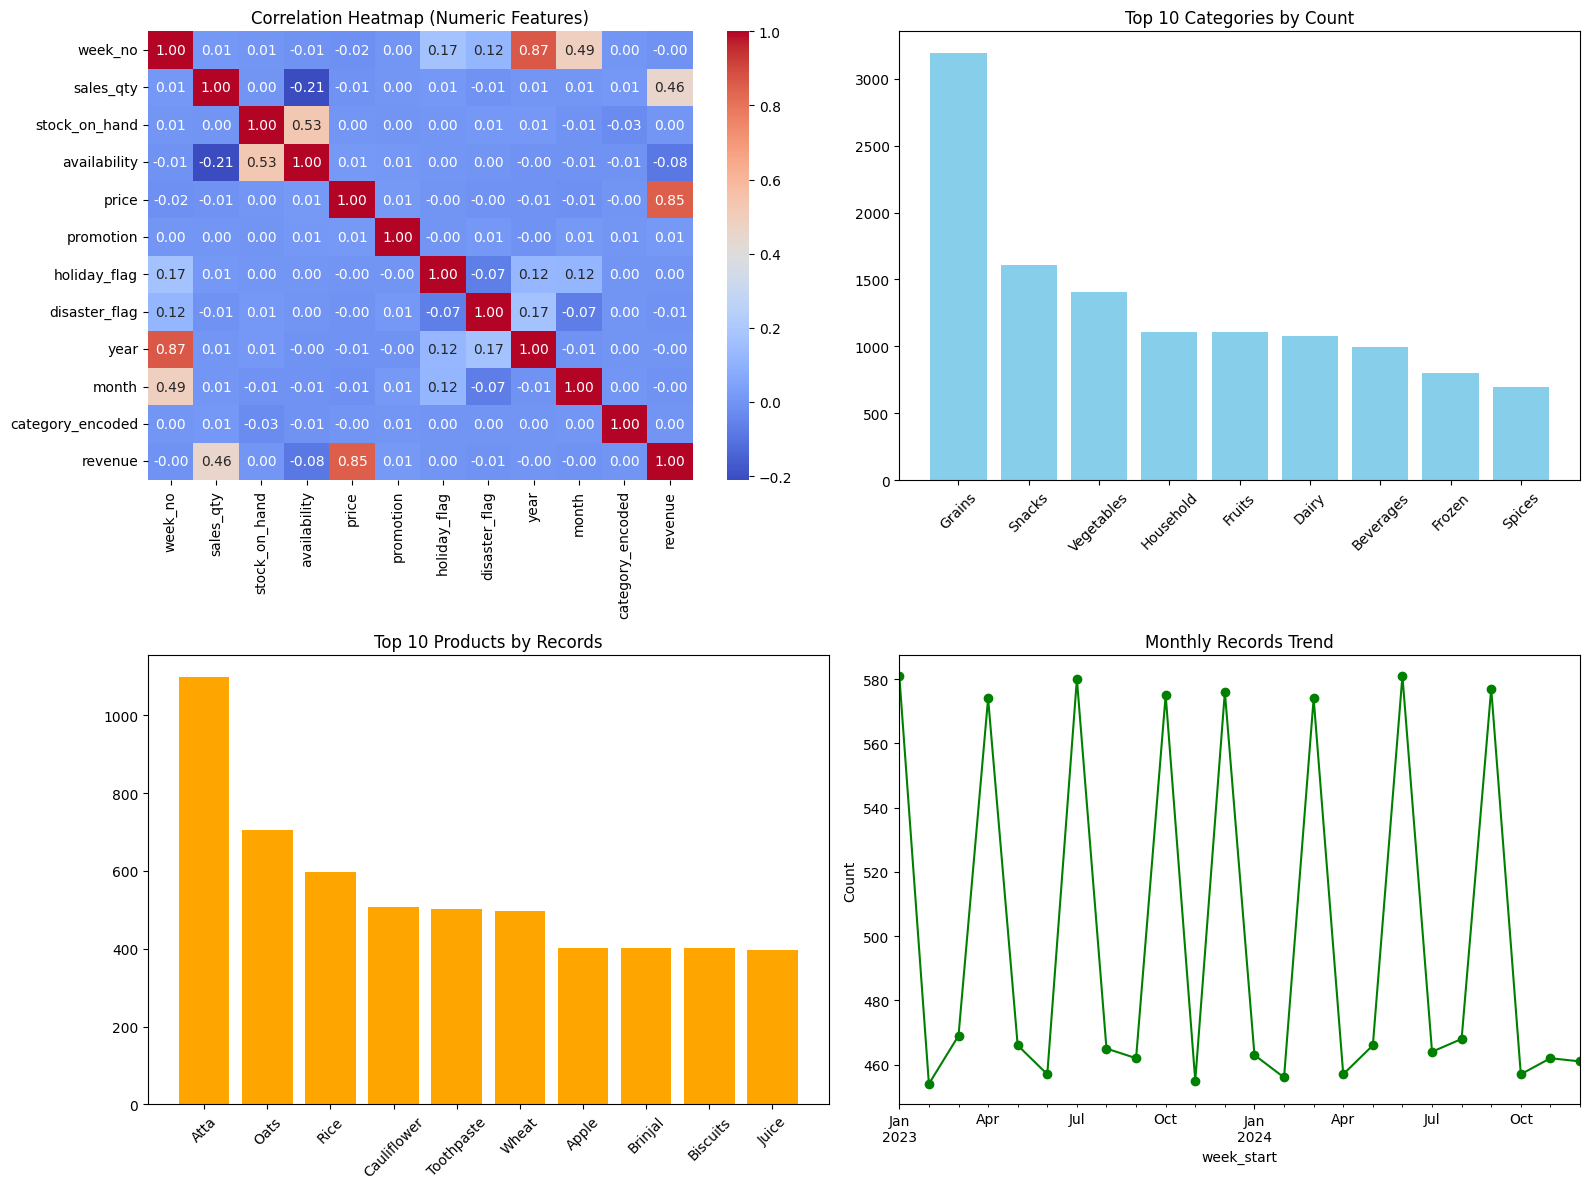

In [ ]:
# -------------------
# Phase 1 - Cell 7: Final Exploratory Analysis with Visualizations
# -------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("📊 FINAL EXPLORATORY DATA ANALYSIS (Phase 1)")
print("=" * 70)

# ----------------------------
# Load cleaned dataset
# ----------------------------
DATA_PATH = os.path.join(PROCESSED_DIR, 'cleaned_data.csv')

if os.path.exists(DATA_PATH):
    df_cleaned = pd.read_csv(DATA_PATH)
    print(f"✅ Loaded cleaned data: {DATA_PATH}")
    print(f"📊 Shape: {df_cleaned.shape[0]} rows, {df_cleaned.shape[1]} columns")
else:
    raise FileNotFoundError(f"❌ Cleaned data not found at {DATA_PATH}")

# ----------------------------
# Basic Dataset Overview
# ----------------------------
print("\n🔎 Dataset Overview:")
print(df_cleaned.info())

print("\n📈 Descriptive Statistics:")
print(df_cleaned.describe(include='all').transpose().head(15))

# ----------------------------
# Missing Value Check
# ----------------------------
print("\n🚨 Missing Value Check:")
missing_summary = df_cleaned.isnull().sum()
print(missing_summary[missing_summary > 0] if missing_summary.sum() > 0 else "✅ No missing values")

# ----------------------------
# Visualizations
# ----------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1️⃣ Correlation Heatmap
numeric_cols = df_cleaned.select_dtypes(include=['number']).columns
if len(numeric_cols) > 1:
    corr_matrix = df_cleaned[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=axes[0,0])
    axes[0,0].set_title("Correlation Heatmap (Numeric Features)")
else:
    axes[0,0].text(0.5, 0.5, "Not enough numeric columns", ha="center", va="center")
    axes[0,0].set_title("Correlation Heatmap")

# 2️⃣ Category Distribution
if 'category' in df_cleaned.columns:
    category_counts = df_cleaned['category'].value_counts().head(10)
    axes[0,1].bar(category_counts.index, category_counts.values, color='skyblue')
    axes[0,1].set_title("Top 10 Categories by Count")
    axes[0,1].tick_params(axis='x', rotation=45)
else:
    axes[0,1].text(0.5, 0.5, "No 'category' column", ha="center", va="center")
    axes[0,1].set_title("Category Distribution")

# 3️⃣ Top Stores or Products
if 'store_id' in df_cleaned.columns:
    top_stores = df_cleaned['store_id'].value_counts().head(10)
    axes[1,0].bar(top_stores.index, top_stores.values, color='orange')
    axes[1,0].set_title("Top 10 Stores by Records")
    axes[1,0].tick_params(axis='x', rotation=45)
elif 'product_name' in df_cleaned.columns:
    top_products = df_cleaned['product_name'].value_counts().head(10)
    axes[1,0].bar(top_products.index, top_products.values, color='orange')
    axes[1,0].set_title("Top 10 Products by Records")
    axes[1,0].tick_params(axis='x', rotation=45)
else:
    axes[1,0].text(0.5, 0.5, "No 'store_id' or 'product_name' column", ha="center", va="center")
    axes[1,0].set_title("Store/Product Distribution")

# 4️⃣ Monthly Trend
if 'date' in df_cleaned.columns:
    df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], errors='coerce')
    monthly_counts = df_cleaned.groupby(df_cleaned['date'].dt.to_period("M")).size()
    monthly_counts.plot(ax=axes[1,1], marker='o', color='green')
    axes[1,1].set_title("Monthly Records Trend")
    axes[1,1].set_ylabel("Count")
elif 'week_start' in df_cleaned.columns:
    df_cleaned['week_start'] = pd.to_datetime(df_cleaned['week_start'], errors='coerce')
    monthly_counts = df_cleaned.groupby(df_cleaned['week_start'].dt.to_period("M")).size()
    monthly_counts.plot(ax=axes[1,1], marker='o', color='green')
    axes[1,1].set_title("Monthly Records Trend")
    axes[1,1].set_ylabel("Count")
else:
    axes[1,1].text(0.5, 0.5, "No 'date' or 'week_start' column", ha="center", va="center")
    axes[1,1].set_title("Monthly Trend")

plt.tight_layout()
plt.show()
